In [3]:
import numpy as np
import json
import yaml
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from matplotlib.ticker import MaxNLocator

import xobjects as xo
import xtrack as xt
import xpart as xp

import os

import pymadx
from xcoll_plotting import plot_functions as xcp

No pytransport functionality
No pytransport functionality


# BLM

In [4]:
line_inj = os.path.expandvars("${HOME_TWOCRYST}/MadX/2024/track_injection_b2.json")
#line_1TeV = os.path.expandvars("${HOME_TWOCRYST}/MadX/2024/track_ramp.9_b2.json")
#line_3TeV = os.path.expandvars("${HOME_TWOCRYST}/MadX/2024/track_ramp.12_b2.json")
#line_5TeV = os.path.expandvars("${HOME_TWOCRYST}/MadX/2024/track_ramp.17_b2.json")
#line_FT = os.path.expandvars("${HOME_TWOCRYST}/MadX/2024/track_flat_top_b2.json")

In [5]:
line_file = line_inj

In [6]:
TCCP_bending_angle = 6921.3e-6
TCCS_bending_angle = 50e-6
TCCP_length = 0.070
TARGET_length =  0.005
TCCS_length = 0.004

In [7]:
# ------------ SETUP LINE AND TWISS ----------------

line = xt.Line.from_json(line_file)

end_s = line.get_length()

TCCS_name = 'tccs.5r3.b2'
TCCP_name = 'tccp.4l3.b2'
TARGET_name = 'target.4l3.b2'
PIXEL_name = 'pixel.detector'
ALFA_name = 'alfa.detector'
TCP_name = 'tcp.d6r7.b2'
TCLA_name = 'tcla.a5l3.b2'

d_PIXEL = 0.663 # [m]
ydim_PIXEL = 0.01408
xdim_PIXEL = 0.04224 #0.04246

d_ALFA = 0.720 + 0.663 # [m]
ydim_ALFA = 0.029698484809835
xdim_ALFA = 0.04525483399593905 

TCCS_loc = end_s - 6773.9428 #6773.7 #6775
TCCP_loc = end_s - (6653.0468 + 207.5e-3) #6655

dx = 1e-11
TARGET_loc = end_s - (6653.0468 + 243.75e-3)
PIXEL_loc = end_s - (6653.3 - TCCP_length/2 - d_PIXEL)
ALFA_loc = end_s - (6653.3 - TCCP_length/2 - d_ALFA )
TCP_loc = line.get_s_position()[line.element_names.index(TCP_name)]
TCLA_loc = line.get_s_position()[line.element_names.index(TCLA_name)]


line.insert_element(at_s=TCCS_loc, element=xt.Marker(), name=TCCS_name)
line.insert_element(at_s=TCCS_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name=TCCS_name+'_aper')
line.insert_element(at_s=TCCS_loc - TCCS_length/2, element=xt.Marker(), name=TCCS_name+'_exit')
line.insert_element(at_s=TCCS_loc + TCCS_length/2, element=xt.Marker(), name=TCCS_name+'_entry')
line.insert_element(at_s=TCCP_loc, element=xt.Marker(), name=TCCP_name)
line.insert_element(at_s=TCCP_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name=TCCP_name+'_aper')
line.insert_element(at_s=TCCP_loc - TCCP_length/2, element=xt.Marker(), name=TCCP_name+'_exit')
line.insert_element(at_s=TCCP_loc + TCCP_length/2, element=xt.Marker(), name=TCCP_name+'_entry')
line.insert_element(at_s=TARGET_loc, element=xt.Marker(), name=TARGET_name)
line.insert_element(at_s=TARGET_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name= TARGET_name + '_aper')
line.insert_element(at_s=PIXEL_loc, element=xt.Marker(), name=PIXEL_name)
line.insert_element(at_s=ALFA_loc, element=xt.Marker(), name=ALFA_name)

tw = line.twiss()

Loading line from dict:   0%|          | 0/102068 [00:00<?, ?it/s]

Done loading line from dict.           


Slicing line:   0%|          | 0/102068 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102071 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102073 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102075 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102078 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102080 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102082 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102085 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102087 [00:00<?, ?it/s]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [8]:
# ------------ PLOTTING FUNCT and LINES ----------------

def change_coordinates_to_b1(df):
    if 's' in df.columns:
        df['s'] = end_s - df['s']
    else:
        new_index = [end_s - i for i in df.index.values]
        df.index = new_index 
    return df

def reset_coord_cry_tracking_TCCS(df, twiss):
    df['s'] = np.where(df['s'] <=  end_s-TCCS_loc, end_s-TCCS_loc-df['s'], 2*end_s-TCCS_loc-df['s'])
    names = twiss.to_pandas().name.to_numpy()
    idx = np.where(names == TCCS_name)[0][0]
    names = np.roll(names, -idx)
    df['name'] = names
    df = df.sort_values(by="s")
    return df

def reset_coord_cry_tracking_TCCP(df, twiss):
    df['s'] = np.where(df['s'] <=  end_s-TCCP_loc, end_s-TCCP_loc-df['s'], 2*end_s-TCCP_loc-df['s'])
    names = twiss.to_pandas().name.to_numpy()
    idx = np.where(names == TCCP_name)[0][0]
    names = np.roll(names, -idx)
    df['name'] = names
    df = df.sort_values(by="s")
    return df

def get_jaw(name, length, n_env, emittance, tw, end_s, hgap = None,  color = 'r'):
    s_centre = end_s - tw['s', name]
    if hgap is None:
        hgap = n_env*np.sqrt(emittance*tw['bety', name])
    sstart  = s_centre - length/2
    send    = s_centre + length/2
    w       = send-sstart
    top_lim = plt.ylim()[1]*2
    bot_lim = plt.ylim()[0]*2
    h       = top_lim - hgap
    jaw = matplotlib.patches.Rectangle((sstart, hgap), w, h, angle=0.0, 
                                            fc=color, ec=color, zorder=10)
    return jaw

def rad_to_deg(n):
    return n*180/np.pi

def convert_m_to_mm(val):
    return val / 1e-3

def convert_mm_to_m(val):
    return val * 1e-3

def extract_channelled(df):
    df = df.loc[(df['s']<end_s-TCCS_loc) & (df['s']>end_s-TCLA_loc)]
    return df



line_aper =  xt.Line.from_json("../input_files/2023_Run3_flat_top/flat_top_b2.json")
df_apertures = xcp.load_apertures(line_aper)
df_apertures = change_coordinates_to_b1(df_apertures)
layout_file = "../input_files/2023_Run3_flat_top/layout_flat_top_b2.tfs"  
layout_data_object = pymadx.Data.Tfs(layout_file)

Loading line from dict:   0%|          | 0/105797 [00:00<?, ?it/s]

Done loading line from dict.           
pymadx.Tfs.Load> normal file


In [9]:
def CRY_kick(gap, energy, element, tw = tw):

    mp = 0.9382e9
    emittance_n = 3.5e-6
    gamma = energy/mp
    beta = np.sqrt(1-1/(gamma*gamma))
    emittance = emittance_n/(beta*gamma)

    beta_y = tw['bety', element]
    alpha_y = tw['alfy', element]

    #print('beta_y = ', beta_y, 'alpha_y = ', alpha_y)
    return gap*np.sqrt(emittance*beta_y), -gap*alpha_y*np.sqrt(emittance/beta_y)

def get_position(coord, bending_ang = TCCP_bending_angle, length = TCCP_length, aper =  0.040 + 0.0015):
    y = aper - coord[0]
    x = y*np.tan(np.pi/2 - (coord[1] + bending_ang))
    return (6653.0468 + 207.5e-3)  - x

In [10]:
def get_blm_position_TCCP(energy, n_env, y_aper = 0.040 + 0.0015, plot = True, tw = tw, line = line, save = False, start = 6640 , stop = 6670):

    mp = 0.9382e9
    emittance_n = 3.5e-6
    gamma = energy/mp
    beta = np.sqrt(1-1/(gamma*gamma))
    emittance = emittance_n/(beta*gamma)


    context = xo.ContextCpu() 
    part_TCCP = xp.Particles(p0c=energy, #eV
                            q0=1, mass0=xp.PROTON_MASS_EV,
                            x=0,
                            px=0,
                            y = CRY_kick(n_env, energy, TCCP_name + '_exit', tw)[0],
                            py = CRY_kick(n_env, energy, TCCP_name + '_exit', tw)[1] + TCCP_bending_angle,
                            _context=context)
    line.track(part_TCCP, turn_by_turn_monitor = 'ONE_TURN_EBE', ele_start=TCCP_name+'_exit')
    df_TCCP_part = reset_coord_cry_tracking_TCCP(pd.DataFrame(list(zip(line.record_last_track.s[0], -1*line.record_last_track.x[0], line.record_last_track.y[0], line.record_last_track.py[0], line.record_last_track.state[0] )), columns =['s', 'x', 'y', 'py', 'state']), tw)
    df_TCCP_part = df_TCCP_part[df_TCCP_part['y']>0.0]

    print('Angle: ', CRY_kick(n_env, energy, TCCP_name + '_exit', tw)[1] + TCCP_bending_angle)

    m, q = np.polyfit(df_TCCP_part.s, df_TCCP_part.y, 1) 
    y_fit = m * df_TCCP_part.s + q
    s_aper = (y_aper-q)/m


    if plot:
        fig, ax_BLM = plt.subplots(2, 1, gridspec_kw={'height_ratios': [0.1, 1]}, sharex=True, figsize=(15,7))
        pymadx.Plot._SetMachineAxesStyle(ax_BLM[0])
        pymadx.Plot._DrawMachineLattice(ax_BLM[0], layout_data_object)
        ax_BLM[0].set_xlim(start,stop)
        #ir3_plot[0].set_title(label='Energy = 1 TeV', y=1.05, fontsize=18)


        df_ref = change_coordinates_to_b1(tw.to_pandas())
        ax_BLM[1].plot(df_ref["s"],df_ref["y"],color="orange")
        ax_BLM[1].plot(df_ref["s"], n_env*np.sqrt(emittance*df_ref['bety']), color='C1')
        ax_BLM[1].plot(df_ref["s"],-n_env*np.sqrt(emittance*df_ref['bety']), color='C1')
        ax_BLM[1].fill_between(df_ref["s"], n_env*np.sqrt(emittance*df_ref['bety']), -n_env*np.sqrt(emittance*df_ref['bety']), color='C1', alpha=0.3)

        ax_BLM[1].set_xlabel('s [m]',  fontsize=17)
        ax_BLM[1].set_xlim(start, stop)
        ax_BLM[1].set_ylim(-0.06, 0.06)
        ax_BLM[1].set_ylabel('y [m]',  fontsize=17)
        ax_BLM[1].grid(linestyle=':')
        ax_BLM[1].tick_params(axis='both', which='major', labelsize=17)
        xcp.plot_apertures(df_apertures[['xmin', 'xmax', 'ymin', 'ymax']].apply(lambda x: convert_mm_to_m(x)), ax_BLM[1], "v")

        ax_BLM[1].plot(df_TCCP_part["s"],df_TCCP_part["y"], color='darkblue')
        ax_BLM[1].plot(df_TCCP_part["s"], y_fit, color= 'r', linestyle='--')
        ax_BLM[1].plot(s_aper, y_aper, marker='o')
        ax_BLM[1].add_patch(get_jaw(TCCP_name, TCCP_length, n_env, emittance,  tw, end_s))
        ax_BLM[1].add_patch(get_jaw(PIXEL_name, 0.05, n_env, emittance,  tw, end_s, hgap = 0.007, color='green'))
        ax_BLM[1].add_patch(get_jaw(ALFA_name, 0.05, n_env, emittance,  tw, end_s, hgap = 0.007, color='green'))
        ax_BLM[1].plot(get_position(CRY_kick(n_env, energy, TCCP_name+'_exit' , tw)), y_aper, color='k', marker='*')

        if save:
            plt.savefig('../Plots/BLMs_TCCP_{}sig_{}GeV.pdf'.format(n_env, round(energy/1e9)), dpi=300)

    print('sim: ', s_aper, '\t calc: ', get_position(CRY_kick(n_env, energy, TCCP_name+'_exit' , tw)), '\t diff: ', s_aper - get_position(CRY_kick(n_env, energy, TCCP_name+'_exit' , tw)))
    print('distance from centre of TCCP tank: ', 6653.3 - s_aper, '\t safe limit: 5.709 m' )
    return s_aper

Angle:  0.006998892120895566
sim:  6648.352687416126 	 calc:  6648.352767450717 	 diff:  -8.003459061001195e-05
distance from centre of TCCP tank:  4.947312583874009 	 safe limit: 5.709 m


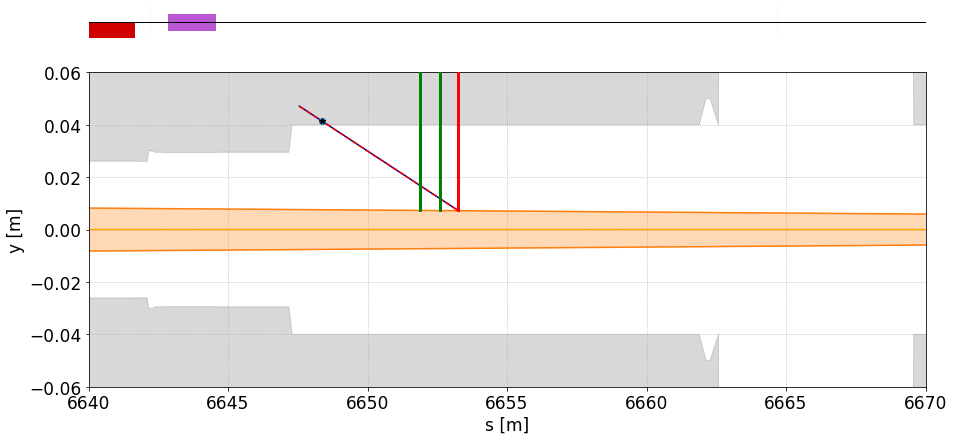

In [11]:
inj_8= get_blm_position_TCCP(450e9, 5, save=True)

Angle:  0.006998892120895566
sim:  6648.352687416126 	 calc:  6648.352767450717 	 diff:  -8.003459061001195e-05
distance from centre of TCCP tank:  4.947312583874009 	 safe limit: 5.709 m


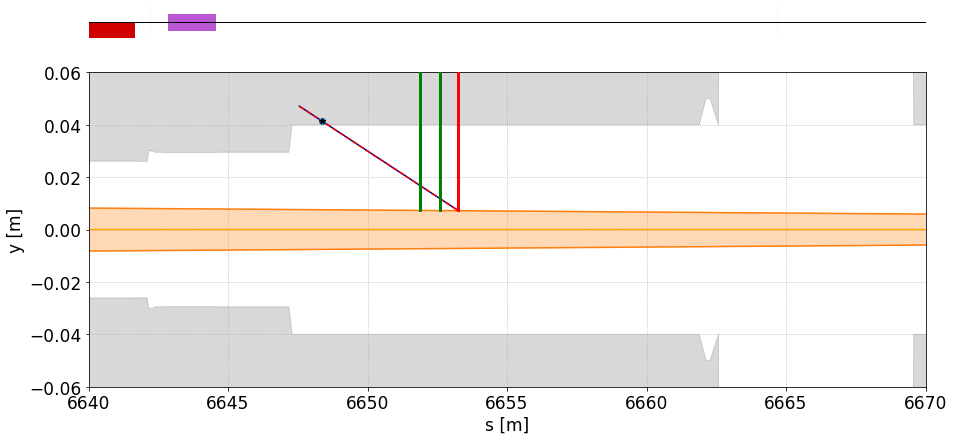

In [12]:
inj_8 = get_blm_position_TCCP(450e9, 5, save = True)

Angle:  0.00697335033194393
sim:  6647.995131155031 	 calc:  6647.995216402249 	 diff:  -8.524721761205001e-05
distance from centre of TCCP tank:  5.304868844968951 	 safe limit: 5.709 m


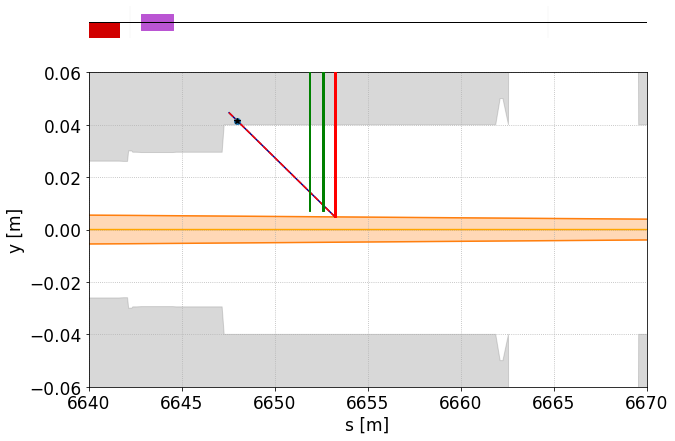

In [11]:
tev1_5 = get_blm_position_TCCP(1000e9, 5)

Angle:  0.006963371774193508
sim:  6647.854730036705 	 calc:  6647.854817309419 	 diff:  -8.727271324460162e-05
distance from centre of TCCP tank:  5.445269963294777 	 safe limit: 5.709 m


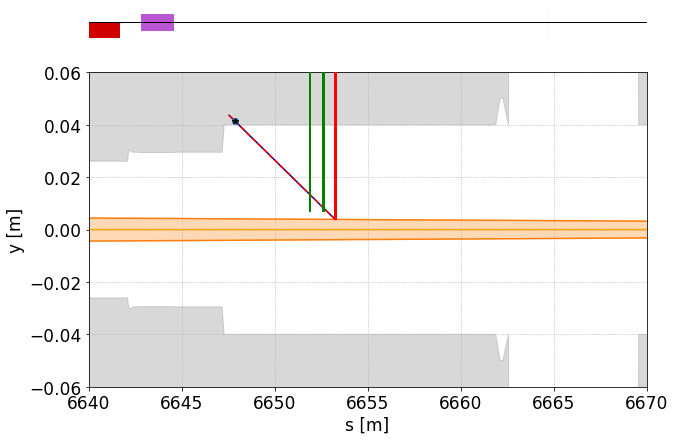

In [13]:
tev3_5 = get_blm_position_TCCP(3000e9, 7)

Angle:  0.00697335033194393
sim:  6647.995131155031 	 calc:  6647.995216402249 	 diff:  -8.524721761205001e-05
distance from centre of TCCP tank:  5.304868844968951 	 safe limit: 5.709 m


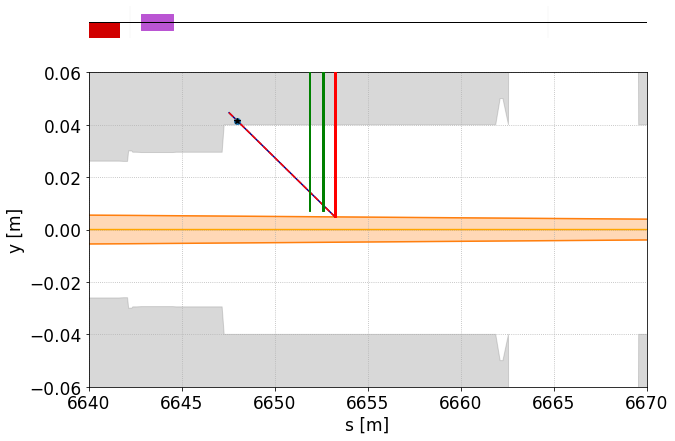

In [24]:
tev1_5 = get_blm_position_TCCP(1000e9, 5, save=True)

Angle:  0.00699889212089628
sim:  6648.352687416135 	 calc:  6648.352767450726 	 diff:  -8.003459061001195e-05
distance from centre of TCCP tank:  4.947312583864914 	 safe limit: 5.709 m


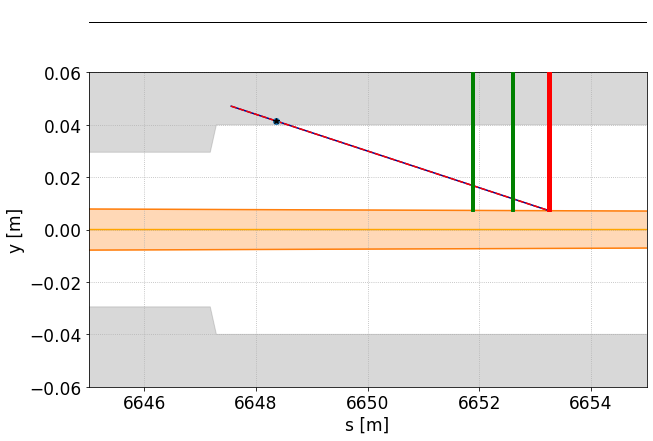

In [26]:
tevinj_5 = get_blm_position_TCCP(450e9, 5, save=True, start=6645, stop=6655)

Angle:  0.006958544177885043
sim:  6647.786659866932 	 calc:  6647.786748117362 	 diff:  -8.825043005344924e-05
distance from centre of TCCP tank:  5.513340133068596 	 safe limit: 5.664 m


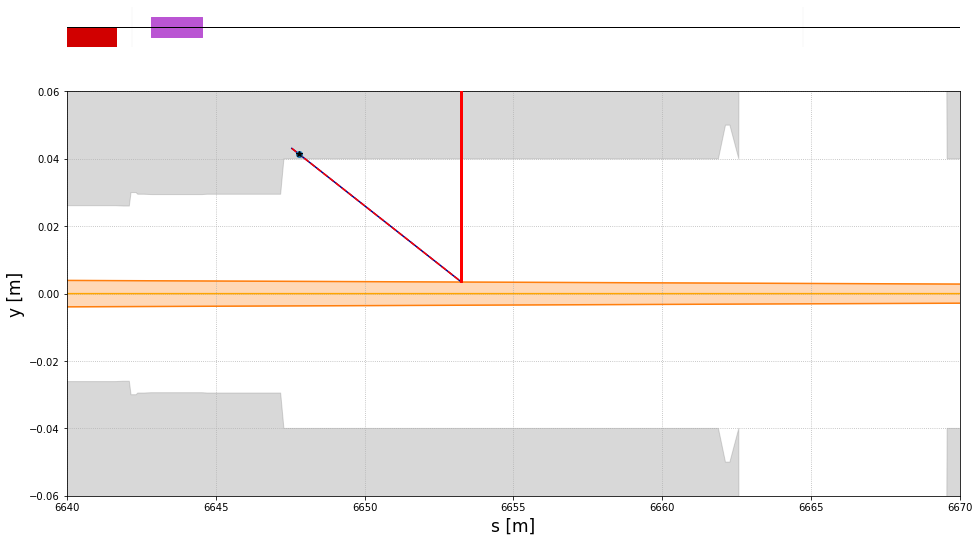

In [138]:
tev5_8 = get_blm_position_TCCP(5000e9, 8, save=True)

Angle:  0.006944577611178152
sim:  6647.589195246778 	 calc:  6647.589286317702 	 diff:  -9.107092409976758e-05
distance from centre of TCCP tank:  5.710804753221964 	 safe limit: 5.709 m


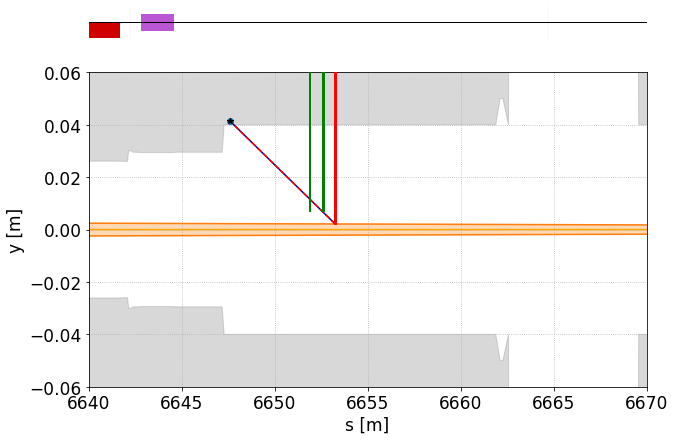

In [44]:
tev5_8 = get_blm_position_TCCP(5000e9, 5, save=True)

In [83]:
6653.3 - 5.664

6647.636

In [68]:
6653.3-6647.8

5.5

In [ ]:
6652.1-0.47-0.21-

sim:  6647.589195246778 	 calc:  6647.5542863177025 	 diff:  0.03490892907575471
distance from centre of TCCP tank:  5.710804753221964 	 safe limit: 5.664 m


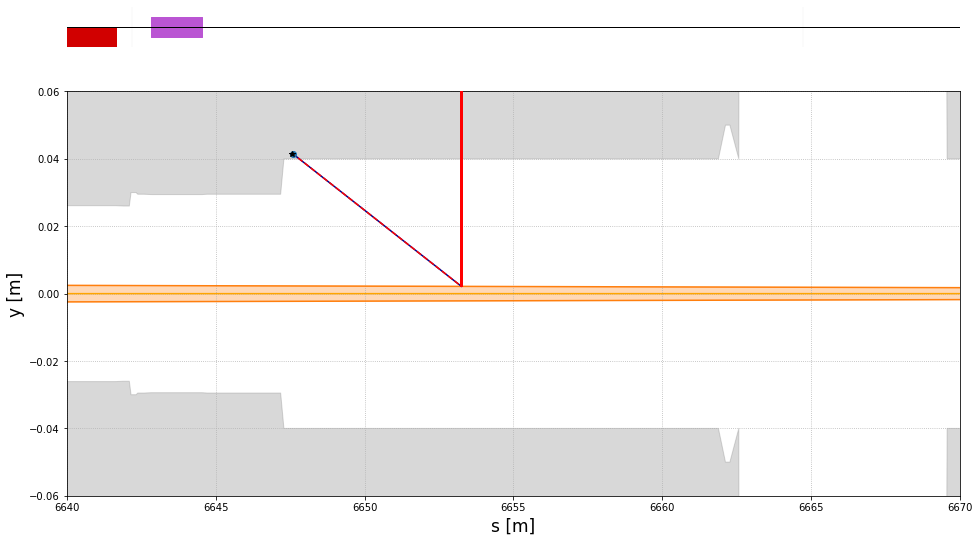

In [15]:
tev5_5 = get_blm_position_TCCP(5000e9, 5)

In [45]:
df_apertures

,xmin,xmax,ymin,ymax,apertype
26658.883171,-0.029000,0.029000,-0.029000,0.029000,LimitEllipse
26657.383171,-9.999999,9.999999,-9.999999,9.999999,LimitRectEllipse
26645.676171,-0.040000,0.040000,-0.040000,0.040000,LimitEllipse
26644.529171,-0.040000,0.040000,-0.040000,0.040000,LimitEllipse
26644.429171,-0.060000,0.060000,-0.060000,0.060000,LimitEllipse
...,...,...,...,...,...
14.424999,-0.060000,0.060000,-0.060000,0.060000,LimitEllipse
14.324999,-0.040000,0.040000,-0.040000,0.040000,LimitEllipse
13.206999,-0.040000,0.040000,-0.040000,0.040000,LimitEllipse
1.499999,-9.999999,9.999999,-9.999999,9.999999,LimitRectEllipse


In [1]:
def get_blm_position_double_chann(energy, n_env, df_apertures, y_aper = 0.040 + 0.0015, plot = True, tw = tw, line = line, save = False):

    mp = 0.9382e9
    emittance_n = 3.5e-6
    gamma = energy/mp
    beta = np.sqrt(1-1/(gamma*gamma))
    emittance = emittance_n/(beta*gamma)
    context = xo.ContextCpu() 
    
    dp = 1.92e-10 
    pot_crit = 21.34
    eta = 0.9
    bending_radius = TCCS_length/TCCS_bending_angle
    Rcrit = energy/(2*np.sqrt(eta)*pot_crit) * (dp/2)
    TCCS_critical_angle = np.sqrt(2*eta*pot_crit/energy)*(1 - Rcrit/bending_radius)



    cry_part_chann = xp.Particles(p0c=energy, #eV
                            q0 = 1, mass0=xp.PROTON_MASS_EV,
                            x = 0,
                            px = 0,
                            y = CRY_kick(n_env, energy, TCCS_name + '_exit', tw)[0],
                            py = CRY_kick(n_env, energy, TCCS_name + '_exit', tw)[1] + TCCS_bending_angle,
                            _context=context)

    cry_part_chann_upper = xp.Particles(p0c=energy, #eV
                            q0 = 1, mass0=xp.PROTON_MASS_EV,
                            x = 0,
                            px = 0,
                            y = CRY_kick(n_env, energy, TCCS_name + '_exit', tw)[0],
                            py = CRY_kick(n_env, energy, TCCS_name + '_exit', tw)[1] + TCCS_bending_angle + TCCS_critical_angle,
                            _context=context)


    cry_part_chann_lower = xp.Particles(p0c=energy, #eV
                            q0 = 1, mass0=xp.PROTON_MASS_EV,
                            x = 0,
                            px = 0,
                            y = CRY_kick(n_env, energy, TCCS_name + '_exit', tw)[0],
                            py = CRY_kick(n_env, energy, TCCS_name + '_exit', tw)[1] + TCCS_bending_angle - TCCS_critical_angle,
                            _context=context)


    line.track(cry_part_chann, turn_by_turn_monitor = 'ONE_TURN_EBE', ele_start=TCCS_name + '_exit')
    df_chann = reset_coord_cry_tracking_TCCS(pd.DataFrame(list(zip(line.record_last_track.s[0], -1*line.record_last_track.x[0], line.record_last_track.y[0], line.record_last_track.py[0])), columns =['s', 'x', 'y', 'py']), tw)
    #df_chann = extract_channelled(df_chann)


    line.track(cry_part_chann_upper, turn_by_turn_monitor = 'ONE_TURN_EBE', ele_start=TCCS_name + '_exit')
    df_chann_upper = reset_coord_cry_tracking_TCCS(pd.DataFrame(list(zip(line.record_last_track.s[0], -1*line.record_last_track.x[0], line.record_last_track.y[0])), columns =['s', 'x', 'y']), tw)
    #df_chann_upper = extract_channelled(df_chann_upper)

    line.track(cry_part_chann_lower, turn_by_turn_monitor = 'ONE_TURN_EBE', ele_start=TCCS_name + '_exit')
    df_chann_lower = reset_coord_cry_tracking_TCCS(pd.DataFrame(list(zip(line.record_last_track.s[0], -1*line.record_last_track.x[0], line.record_last_track.y[0])), columns =['s', 'x', 'y']), tw)
    #df_chann_lower = extract_channelled(df_chann_lower)

    

    part_TCCP = xp.Particles(p0c=energy, #eV
                            q0=1, mass0=xp.PROTON_MASS_EV,
                            x=0,
                            px=0,
                            y=float(df_chann[df_chann['name'] == TCCP_name + '_entry']['y']),
                            py=float(df_chann[df_chann['name'] == TCCP_name + '_entry']['py']) + TCCP_bending_angle,
                            _context=context)


    print('Angle: ', float(df_chann[df_chann['name'] == TCCP_name + '_entry']['py']) + TCCP_bending_angle)
    line.track(part_TCCP, turn_by_turn_monitor = 'ONE_TURN_EBE', ele_start=TCCP_name+'_exit')
    df_TCCP_part = reset_coord_cry_tracking_TCCP(pd.DataFrame(list(zip(line.record_last_track.s[0], -1*line.record_last_track.x[0], line.record_last_track.y[0], line.record_last_track.py[0], line.record_last_track.state[0] )), columns =['s', 'x', 'y', 'py', 'state']), tw)
    df_TCCP_part = df_TCCP_part[df_TCCP_part['y']>0.0]
    df_apertures = df_apertures[df_apertures['ymax'].between(-0.9,0.9)]


    m, q = np.polyfit(df_TCCP_part.s, df_TCCP_part.y, 1) 
    y_fit = m * df_TCCP_part.s + q
    s_aper = (y_aper-q)/m


    if plot:
        start, stop =  6640,6777
        fig, ax_BLM = plt.subplots(2, 1, gridspec_kw={'height_ratios': [0.1, 1]}, sharex=True, figsize=(15,7))
        pymadx.Plot._SetMachineAxesStyle(ax_BLM[0])
        pymadx.Plot._DrawMachineLattice(ax_BLM[0], layout_data_object)
        ax_BLM[0].set_xlim(start,stop)
        #ir3_plot[0].set_title(label='Energy = 1 TeV', y=1.05, fontsize=18)


        df_ref = change_coordinates_to_b1(tw.to_pandas())
        ax_BLM[1].plot(df_ref["s"],df_ref["y"],color="orange")
        ax_BLM[1].plot(df_ref["s"], n_env*np.sqrt(emittance*df_ref['bety']), color='C1')
        ax_BLM[1].plot(df_ref["s"],-n_env*np.sqrt(emittance*df_ref['bety']), color='C1')
        ax_BLM[1].fill_between(df_ref["s"], n_env*np.sqrt(emittance*df_ref['bety']), -n_env*np.sqrt(emittance*df_ref['bety']), color='C1', alpha=0.3)

        ax_BLM[1].plot(df_chann["s"],df_chann["y"], color='darkblue')
        ax_BLM[1].plot(df_chann_upper["s"],df_chann_upper["y"], color='blue')
        ax_BLM[1].plot(df_chann_lower["s"],df_chann_lower["y"], color='blue')
        ax_BLM[1].fill_between(df_chann["s"], df_chann_upper["y"],df_chann_lower["y"], color='blue', alpha=0.3)

        ax_BLM[1].set_xlabel('s [m]',  fontsize=17)
        ax_BLM[1].set_xlim(start, stop)
        ax_BLM[1].set_ylim(-0.045, 0.045)
        #ax_BLM[1].set_ylim(0.01, 0.05)
        ax_BLM[1].set_ylabel('y [m]',  fontsize=17)
        ax_BLM[1].grid(linestyle=':')
        ax_BLM[1].tick_params(axis='both', which='major', labelsize=17)
        xcp.plot_apertures(df_apertures[['xmin', 'xmax', 'ymin', 'ymax']].apply(lambda x: convert_mm_to_m(x)), ax_BLM[1], "v")

        ax_BLM[1].plot(df_TCCP_part["s"],df_TCCP_part["y"], color='darkblue')
        ax_BLM[1].plot(df_TCCP_part["s"], y_fit, color= 'r', linestyle='--')
        ax_BLM[1].plot(s_aper, y_aper, marker='o')        
        ax_BLM[1].add_patch(get_jaw(PIXEL_name, 0.06, n_env, emittance,  tw, end_s, hgap = 0.010, color='green'))
        ax_BLM[1].add_patch(get_jaw(ALFA_name, 0.06, n_env, emittance,  tw, end_s, hgap = 0.010, color='green'))
        ax_BLM[1].add_patch(get_jaw(TCCP_name, TCCP_length, n_env, emittance, tw, end_s, hgap = float(df_chann[df_chann['name'] == TCCP_name + '_entry']['y'])))
        ax_BLM[1].add_patch(get_jaw(TCCS_name, TCCS_length, n_env, emittance, tw, end_s))
        ax_BLM[1].plot(get_position([float(df_chann[df_chann['name'] == TCCP_name + '_entry']['y']), float(df_chann[df_chann['name'] == TCCP_name + '_entry']['py']) ] ), y_aper, color='k', marker='*')

        if save:
            plt.savefig('../Plots/BLMs_double_chann_{}sig_{}GeV.pdf'.format(n_env, round(energy/1e9)), dpi=300)
            
    print('sim: ', s_aper, '\t calc: ', get_position([float(df_chann[df_chann['name'] == TCCP_name + '_entry']['y']),float(df_chann[df_chann['name'] == TCCP_name + '_entry']['py']) ]), '\t diff: ', s_aper - get_position([float(df_chann[df_chann['name'] == TCCP_name + '_entry']['y']),float(df_chann[df_chann['name'] == TCCP_name + '_entry']['py']) ] ))
    print('distance from centre of TCCP tank: ', 6653.3 - s_aper, '\t safe limit: 5.709 m' )
    return s_aper

NameError: name 'tw' is not defined

In [2]:
dc_inj_3  = get_blm_position_double_chann(450e9, 5, df_apertures, save= False)

NameError: name 'get_blm_position_double_chann' is not defined

In [22]:
end_s - TCCS_loc

6773.942800000001

Angle:  0.00708803928609981
sim:  6649.451846917354 	 calc:  6649.451910596358 	 diff:  -6.36790045973612e-05
distance from centre of TCCP tank:  3.848153082646604 	 safe limit: 5.709 m


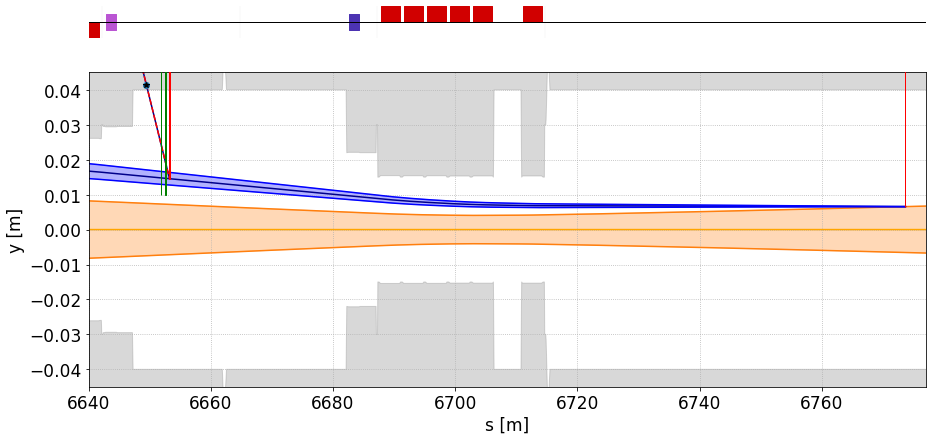

In [53]:
dc_inj_3  = get_blm_position_double_chann(450e9, 5, df_apertures, save= False)

In [33]:
a = df_apertures.reset_index()
a = a.rename(columns={'index': 's'})

In [35]:
b = a[a['s'].between(6640, 6775)][['s', 'ymin','ymax']]

In [ ]:
b.to_csv('../Outputdata/apertures.csv', index= False)

In [43]:
b.groupby('ymax').max().sort_values(by='s').reset_index()[['s', 'ymax', 'ymin']]

,s,ymax,ymin
0,6641.639793,0.026100,-0.026100
1,6642.095793,0.026000,-0.026000
2,6644.540793,0.029400,-0.029400
3,6647.180793,0.029500,-0.029500
4,6664.720793,9.999999,-9.999999
5,6684.270793,0.022100,-0.022100
6,6687.060793,0.022000,-0.022000
7,6690.909793,0.015430,-0.015430
8,6698.509793,0.015400,-0.015400
9,6702.309793,0.015320,-0.015320


Angle:  0.00708803928609981
sim:  6649.451846917354 	 calc:  6649.451910596358 	 diff:  -6.36790045973612e-05
distance from centre of TCCP tank:  3.848153082646604 	 safe limit: 5.709 m


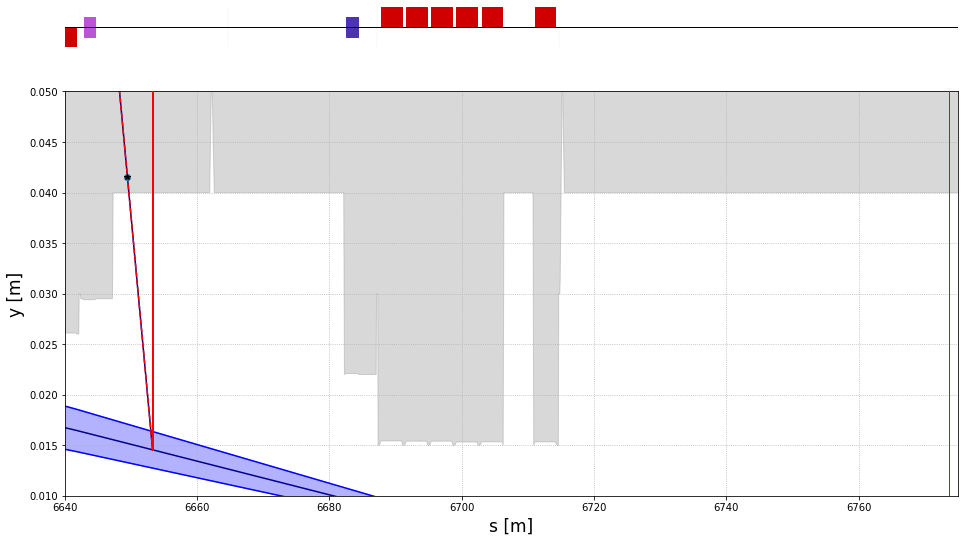

In [72]:
dc_inj_3  = get_blm_position_double_chann(450e9, 5, df_apertures, save= True)

In [38]:
line.get_length()

26658.88317064787

In [39]:
potato[potato.s.between(line.get_length()-6670,line.get_length()-6660)]

,name,s,x,px,y,py,zeta,delta,ptau,W_matrix,...,bx_chrom,by_chrom,ax_chrom,ay_chrom,wx_chrom,wy_chrom,ddx,ddpx,ddy,ddpy
74993,vamfb.4r3.b.b2_aper,19989.007377,-0.000002,-3.868092e-08,2.959998e-07,2.889257e-09,-0.000016,-0.000005,-0.000005,"[[12.096351829063897, -4.440892098500626e-16, ...",...,0.572490,6.643218,-24.932067,22.594439,24.938639,23.550818,1548.322329,32.30624,-521.069578,-4.771812
74994,vamfb.4r3.b.b2,19989.007377,-0.000002,-3.868092e-08,2.959998e-07,2.889257e-09,-0.000016,-0.000005,-0.000005,"[[12.096351829063897, -4.440892098500626e-16, ...",...,0.572490,6.643218,-24.932067,22.594439,24.938639,23.550818,1548.322329,32.30624,-521.069578,-4.771812
74995,vmaaf.4r3.b.b2_aper,19989.007377,-0.000002,-3.868092e-08,2.959998e-07,2.889257e-09,-0.000016,-0.000005,-0.000005,"[[12.096351829063897, -4.440892098500626e-16, ...",...,0.572490,6.643218,-24.932067,22.594439,24.938639,23.550818,1548.322329,32.30624,-521.069578,-4.771812
74996,vmaaf.4r3.b.b2,19989.007377,-0.000002,-3.868092e-08,2.959998e-07,2.889257e-09,-0.000016,-0.000005,-0.000005,"[[12.096351829063897, -4.440892098500626e-16, ...",...,0.572490,6.643218,-24.932067,22.594439,24.938639,23.550818,1548.322329,32.30624,-521.069578,-4.771812
74997,vcda.4r3.a.b2_aper,19989.007377,-0.000002,-3.868092e-08,2.959998e-07,2.889257e-09,-0.000016,-0.000005,-0.000005,"[[12.096351829063897, -4.440892098500626e-16, ...",...,0.572490,6.643218,-24.932067,22.594439,24.938639,23.550818,1548.322329,32.30624,-521.069578,-4.771812
74998,vcda.4r3.a.b2,19989.007377,-0.000002,-3.868092e-08,2.959998e-07,2.889257e-09,-0.000016,-0.000005,-0.000005,"[[12.096351829063897, -4.440892098500626e-16, ...",...,0.572490,6.643218,-24.932067,22.594439,24.938639,23.550818,1548.322329,32.30624,-521.069578,-4.771812
74999,drift_23633,19989.007377,-0.000002,-3.868092e-08,2.959998e-07,2.889257e-09,-0.000016,-0.000005,-0.000005,"[[12.096351829063897, -4.440892098500626e-16, ...",...,0.572490,6.643218,-24.932067,22.594439,24.938639,23.550818,1548.322329,32.30624,-521.069578,-4.771812
75000,vcda.a4l3.b.b2_aper,19989.307377,-0.000002,-3.868092e-08,2.968666e-07,2.889257e-09,-0.000016,-0.000005,-0.000005,"[[12.033004660538461, 0.0, 4.3201949271901314e...",...,0.685776,6.565310,-24.940781,22.607127,24.950208,23.541145,1558.009187,32.30624,-522.500337,-4.771812
75001,vcda.a4l3.b.b2,19989.307377,-0.000002,-3.868092e-08,2.968666e-07,2.889257e-09,-0.000016,-0.000005,-0.000005,"[[12.033004660538461, 0.0, 4.3201949271901314e...",...,0.685776,6.565310,-24.940781,22.607127,24.950208,23.541145,1558.009187,32.30624,-522.500337,-4.771812
75002,vamfb.4r3.a.b2_aper,19989.307377,-0.000002,-3.868092e-08,2.968666e-07,2.889257e-09,-0.000016,-0.000005,-0.000005,"[[12.033004660538461, 0.0, 4.3201949271901314e...",...,0.685776,6.565310,-24.940781,22.607127,24.950208,23.541145,1558.009187,32.30624,-522.500337,-4.771812


In [42]:
line.element_dict['ip3_aper']

LimitRectEllipse(max_x=10, max_y=10, a_squ=100, b_squ=100, a_b_squ=1e+04, _sin_rot_s=-999, _cos_rot_s=-999, _shift_x=0, _shift_y=0, _shift_s=0)

Angle:  0.00708803928609981
sim:  6649.451846917354 	 calc:  6649.451910596358 	 diff:  -6.36790045973612e-05
distance from centre of TCCP tank:  3.848153082646604 	 safe limit: 5.664 m


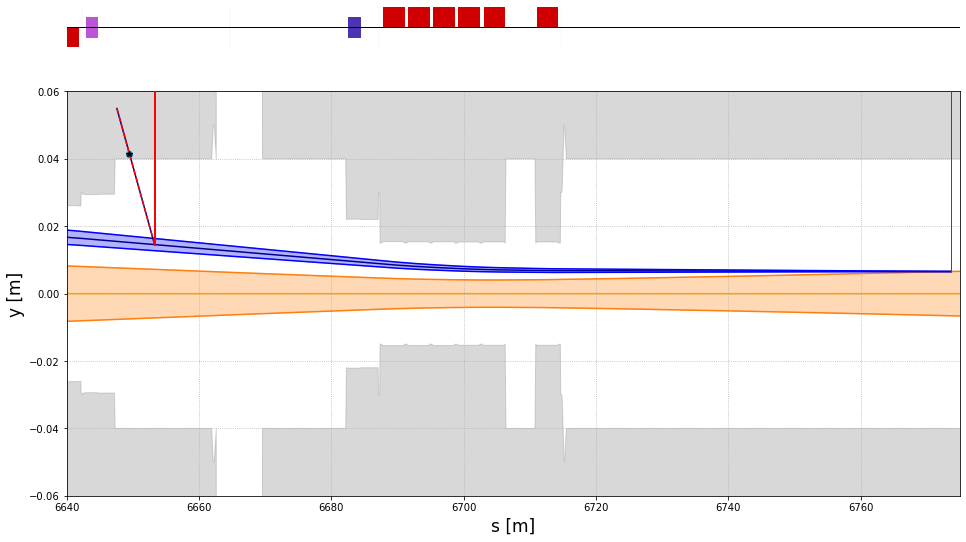

In [142]:
dc_inj_5  = get_blm_position_double_chann(450e9, 5)

In [26]:
line

Angle:  0.007078021622559218
sim:  6649.2314117468595 	 calc:  6649.231478927158 	 diff:  -6.718029817420756e-05
distance from centre of TCCP tank:  4.0685882531406605 	 safe limit: 5.709 m


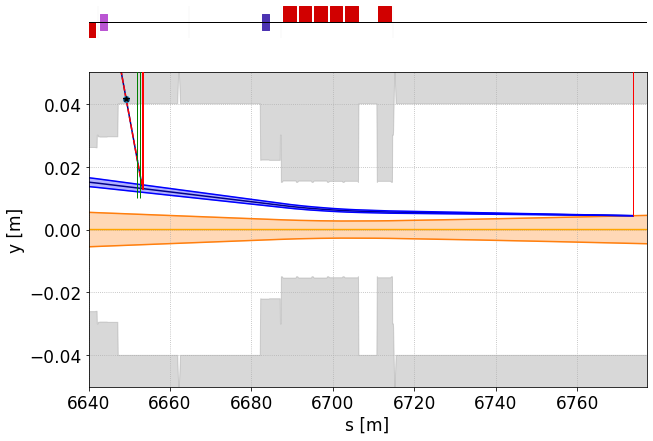

In [61]:
_  = get_blm_position_double_chann(1000e9, 5, df_apertures, save= True)

Angle:  0.007069393439607299
sim:  6649.04105084434 	 calc:  6649.04112103214 	 diff:  -7.018779979262035e-05
distance from centre of TCCP tank:  4.258949155660048 	 safe limit: 5.664 m


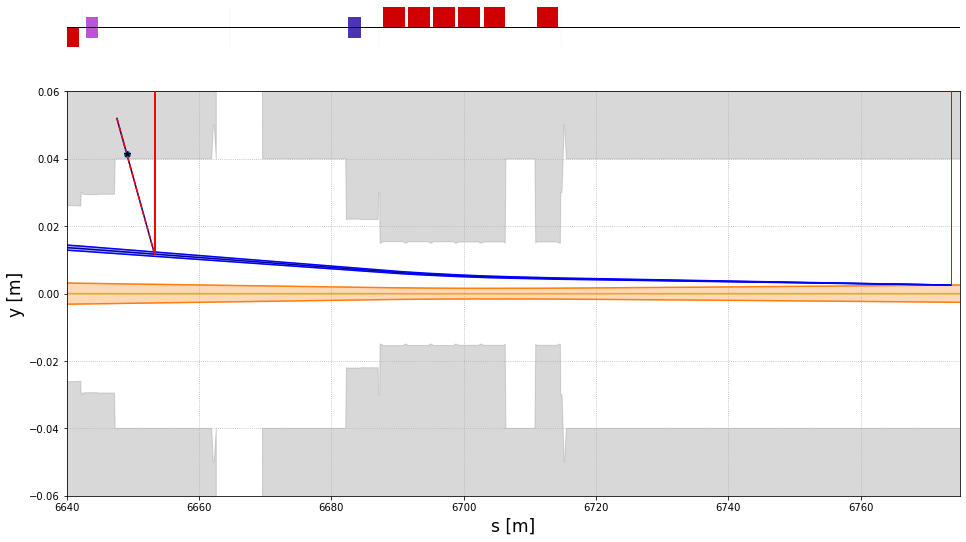

In [145]:
_  = get_blm_position_double_chann(3000e9, 5)

Angle:  0.007066736765562056
sim:  6648.982343876032 	 calc:  6648.982414988342 	 diff:  -7.111230934242485e-05
distance from centre of TCCP tank:  4.317656123967936 	 safe limit: 5.664 m


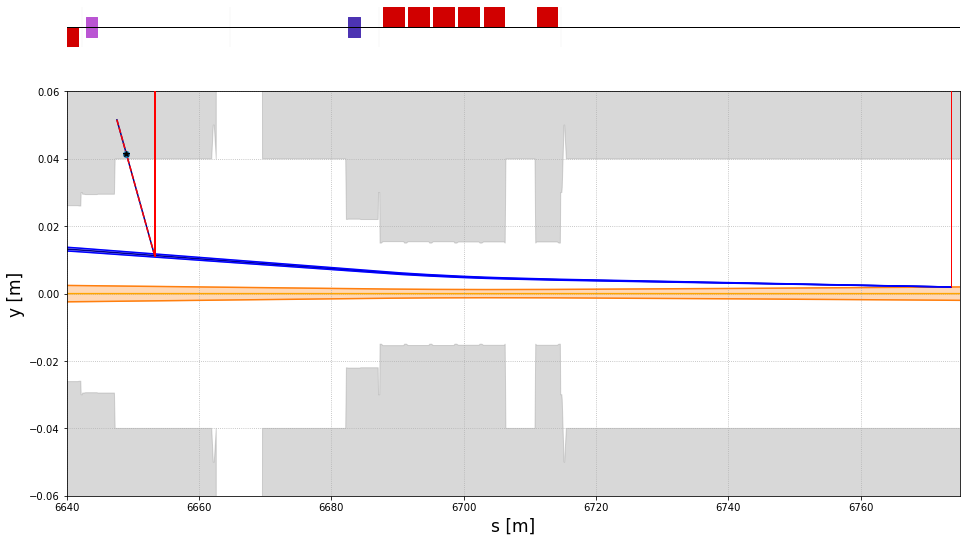

In [143]:
dc_tev5_5  = get_blm_position_double_chann(5000e9, 5, save = False)

In [31]:
abs(tev5_5 - dc_inj_5) / 0.6

3.104419450958934

In [32]:
abs(tev5_8 - dc_inj_5) / 0.6

2.7753117507033194

In [86]:
6648.4 - 6653.3

-4.900000000000546

#### Checks on entry 

In [ ]:
print(tw['bety', TCCP_name + '_entry'], tw['alfy', TCCP_name + '_entry'])
print(tw['bety', TCCP_name], tw['alfy', TCCP_name])
print(tw['bety', TCCP_name + '_exit'], tw['alfy', TCCP_name + '_exit'])


In [ ]:
print(CRY_kick(5, 450e9, TCCP_name + '_entry', tw))
print(CRY_kick(5, 450e9, TCCP_name, tw))
print(CRY_kick(5, 450e9, TCCP_name + '_exit', tw))
print(TCCP_bending_angle)

In [ ]:
print(get_position(CRY_kick(5, 450e9, TCCP_name + '_entry', tw)))
print(get_position(CRY_kick(5, 450e9, TCCP_name, tw)))
print(get_position(CRY_kick(5, 450e9, TCCP_name+'_exit' , tw)))


#### Checks on geomrtry 

In [ ]:
(6653.5528 -6653.0468)*1e3

506.00000000031287

In [ ]:
262.25+243.75

506.0

In [ ]:
6653.0468 + 0.2075 

6653.2543000000005

In [ ]:
6653.0468 + 0.2075 - TCCP_length/2

6653.219300000001

In [ ]:
6653.0468 + 0.2075 + TCCP_length/2

6653.2893

In [ ]:
(TCCP_length/2 + TARGET_length/2)*1e3

37.50000000000001

In [ ]:
262.25+243.75 - 207.5 - 262.25

36.25

In [ ]:
(36.25*1e-3 - TCCP_length/2)*2

0.0024999999999999883

In [ ]:
TARGET_length

0.005

In [ ]:
6653.0468 + (243.75)*1e-3

6653.29055

In [ ]:
6653.0468 + (207.5)*1e-3

6653.2543000000005

In [34]:
abs(6773.7208  - 6774.1218) 

0.40099999999983993

In [43]:
6773.7208 + 0.179 


6773.8998

In [37]:
6773.9 - 6773.7208 

0.17919999999958236

In [42]:
6773.7208 + 0.401/2

6773.9213

In [39]:
6774.1218 - 0.222

6773.8998

In [41]:
6774.1218 - 0.401/2

6773.9213

In [44]:
abs(6653.0468 - 6653.5528)

0.5060000000003129

In [46]:
0.24375+0.26225

0.506

In [49]:
0.2075+0.03625+0.26225

0.506

In [47]:
6653.0468+0.506/2

6653.2998

In [54]:
#CENTRE tccp 
6653.0468 + 0.2075

6653.2543000000005

In [55]:
# EXIT TCCP
6653.0468 + 0.2075 + TCCP_length/2

6653.2893

In [56]:
#ENTRANCE TCCP
6653.0468 - 0.2075 - TCCP_length/2

6652.8043

In [57]:
6653.2543 - 6653.3

-0.045700000000579166

limit

In [99]:
(3916 + 2584 - 538 - (262.25+243.75)/2)*1e-3

5.7090000000000005

In [94]:
round(abs(6653.0468 - 6653.5528), 5)

0.506

In [88]:
262.25+243.75

506.0

In [101]:
6653.3+0.506/2+0.538 -2.584 - 3.916

6647.590999999999

In [102]:
6653.3- 5.709

6647.591

In [103]:
6647.591 - 6647.8

-0.20899999999983265

In [105]:
6653.3 - 6647.8

5.5

In [106]:
6653.3 -6647.591

5.708999999999833

In [122]:
6647.591 + 0.6

6648.191000000001

In [127]:
6648.40 + 0.3

6648.7